# Classify audio effects on guitar samples

## 0. Import and config

In [1]:
import os
import time
import numpy as np
import pandas as pd
import scipy
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import sklearn

In [38]:
# Setup variables
samplerate = 44100
sample_len = 2*samplerate
n_mfcc = 13
hop_len = 512
mfcc_len = int(np.ceil(sample_len/hop_len))
feature_len = (mfcc_len*3)
print(feature_len)

519


## 1. Import and prepare data

In [39]:
#get audio files
fileswchorus = os.listdir('./DataSet/Samples/Chorus')
fileswdistortion = os.listdir('./DataSet/Samples/Distortion')
filesweq = os.listdir('./DataSet/Samples/EQ')
fileswdelay = os.listdir('./DataSet/Samples/FeedbackDelay')
fileswflanger = os.listdir('./DataSet/Samples/Flanger')
fileswnofx = os.listdir('./DataSet/Samples/NoFX')

#calc number of samples
n_data = len(fileswchorus)+len(fileswdistortion)+len(filesweq)+len(fileswdelay)+len(fileswflanger)+len(fileswnofx)
print("Number of samples: %i" % n_data)

#setup classes
labels = np.zeros(n_data)
features = np.zeros((n_data, feature_len))
classes = ['Chorus','Distortion','EQ','FeedbackDelay','Flanger','NoFX']

Number of samples: 9360


## 2.a Extract features

In [48]:
from IPython.display import clear_output
start_time = time.time()
count = 0

def extract_features(filename, count=0):
    signal, dummy = librosa.load(filename, samplerate, mono=True)
    mfccs = librosa.feature.mfcc(signal, samplerate, n_mfcc=n_mfcc, hop_length=hop_len)
    mfccs_mean = np.mean(mfccs,0).flatten()
    mfccs_std = np.std(mfccs,0).flatten()
    spec_band = librosa.feature.spectral_bandwidth(signal, samplerate).flatten()
    output = np.concatenate((mfccs_mean, mfccs_std, spec_band))
    clear_output(wait=True)
    print("%i/%i samples processed" % (count, n_data))
    #print(output)
    return output
    
idx = 0
    
for x in fileswchorus:
    count = count+1
    output = extract_features('./DataSet/Samples/Chorus/' + x, count)
    features[idx,:] = output
    labels[idx] = 0
    idx = idx+1
    
for x in fileswdistortion:
    count = count+1
    output = extract_features('./DataSet/Samples/Distortion/' + x, count)
    features[idx,:] = output
    labels[idx] = 1
    idx = idx+1    
        
for x in filesweq:
    count = count+1
    output = extract_features('./DataSet/Samples/EQ/' + x, count)
    features[idx,:] = output
    labels[idx] = 2
    idx = idx+1    
    
for x in fileswdelay:
    count = count+1
    output = extract_features('./DataSet/Samples/FeedbackDelay/' + x, count)
    features[idx,:] = output
    labels[idx] = 3
    idx = idx+1    

for x in fileswflanger:
    count = count+1
    output = extract_features('./DataSet/Samples/Flanger/' + x, count)
    features[idx,:] = output
    labels[idx] = 4
    idx = idx+1    

for x in fileswnofx:
    count = count+1
    output = extract_features('./DataSet/Samples/NoFX/' + x, count)
    features[idx,:] = output
    labels[idx] = 5
    idx = idx+1    

print("Feature extraction done")
print("Took %d seconds" % (time.time() - start_time))

9360/9360 samples processed
Feature extraction done
Took 390 seconds


In [49]:
labels = pd.DataFrame(labels)
labels.columns = ['labels']
labels = labels['labels']

### Save features to .csv

In [6]:
dataset = pd.DataFrame(features)
column_names = []
for c in range(feature_len):
    column_names.append("Feat %i" % c)
dataset.columns =  column_names
dataset['label digit'] = labels
label_text = []
for l in labels:
    label_text.append(classes[int(l)])
dataset['label text'] = label_text
dataset.to_csv('features.csv')
dataset

,Feat 0,Feat 1,Feat 2,Feat 3,Feat 4,Feat 5,Feat 6,Feat 7,Feat 8,Feat 9,...,Feat 1123,Feat 1124,Feat 1125,Feat 1126,Feat 1127,Feat 1128,Feat 1129,Feat 1130,label digit,label text
0,-784.702332,-784.702332,-784.702332,-783.191589,-780.561096,-780.741699,-779.379578,-780.059937,-780.545044,-779.264648,...,-9.980167,-9.575130,-11.077902,-10.313608,-9.547455,-8.738466,-9.587674,-6.503111,0.0,Chorus
1,-761.046631,-761.046631,-761.046631,-760.790771,-758.623718,-758.156921,-756.930786,-757.317566,-757.418396,-756.323364,...,-11.614445,-10.615732,-10.760288,-10.884594,-8.935947,-10.373097,-10.659937,-7.882442,0.0,Chorus
2,-755.930176,-755.930176,-755.930176,-755.882141,-755.104919,-753.960022,-752.564697,-752.798523,-752.437561,-752.191284,...,-9.644500,-5.715909,-3.048868,-2.390507,-0.943978,-2.096195,-3.543271,-2.525408,0.0,Chorus
3,-775.834900,-775.834900,-775.834900,-775.834900,-775.834900,-771.108582,-766.405090,-763.087646,-762.393433,-763.058472,...,-5.656474,-5.338774,-5.956665,-6.357945,-5.982137,-5.842979,-4.504141,-2.002567,0.0,Chorus
4,-745.423096,-745.423096,-745.423096,-745.423096,-745.423096,-743.130554,-740.174133,-737.529724,-736.178650,-735.844055,...,-6.135539,-7.253041,-7.990482,-7.548039,-7.059709,-6.347627,-4.458066,-1.742748,0.0,Chorus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9355,-841.276550,-841.276550,-841.276550,-841.276550,-841.276550,-841.276550,-841.276550,-841.276550,-841.276550,-841.276550,...,17.676605,18.026758,18.565594,17.836399,16.837769,15.430470,12.818876,10.243580,5.0,NoFX
9356,-839.416626,-839.416626,-839.416626,-839.416626,-839.416626,-839.416626,-839.416626,-839.416626,-839.416626,-839.416626,...,26.542507,25.427277,23.974236,21.803810,19.794647,17.421839,14.595476,12.041007,5.0,NoFX
9357,-841.595947,-841.595947,-841.595947,-841.595947,-841.595947,-841.595947,-841.595947,-841.595947,-841.595947,-841.595947,...,25.770664,24.639793,23.246094,21.348425,19.865543,17.576389,14.275450,10.246469,5.0,NoFX
9358,-828.064514,-828.064514,-828.064514,-828.064514,-828.064514,-828.064514,-828.064514,-828.064514,-828.064514,-828.064514,...,20.394966,18.981857,18.081066,16.769773,15.511858,13.729324,10.692130,7.975833,5.0,NoFX


In [50]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2, random_state=6)

In [51]:
#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

## Dimensionality reduction

(9360, 5)


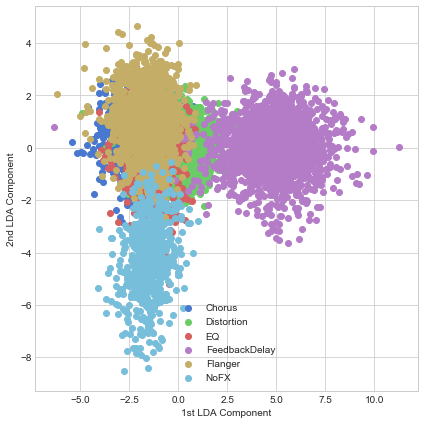

In [69]:
#Creating an instance of the LDA object, which is an object capable of learning and applying LDA from/to data.
#if we want to keep only a given number of components we can use the argument "n_components"
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()


#LDA needs BOTH features and labels (as numbers), other techniques needs only features
lda.fit(features, labels)

#Now we project the data into a from a 7D to a (number of classes - 1) space,
#if the number of components in scikit-learn, LDA transform the data to a number of dimensions
#equal to min(n_classes - 1), which in our case is 4 classes -1 = 3.
#with more classess we will have more dimensions at the output of LDA projection
projected_features = lda.transform(features)

#the dimensionality should be the same number of classes - 1
print(projected_features.shape)

#Plot the distribution of the data according to the first two LDA components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 1],
                    projected_features[labels==lab_val, 2],
                    label=lab_name)
    plt.xlabel('1st LDA Component')
    plt.ylabel('2nd LDA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [71]:
from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(projected_features, labels, test_size=0.2, random_state=6)

#learning the scaling transformation from the train data and applying it to both train and test set.

#creating scaling object
scaler = sklearn.preprocessing.StandardScaler()

#learning scaling from train set
scaler.fit(feat_train)

#applying scaling to both train and test set
feat_train = scaler.transform(feat_train)
feat_test = scaler.transform(feat_test)

(9360, 519)


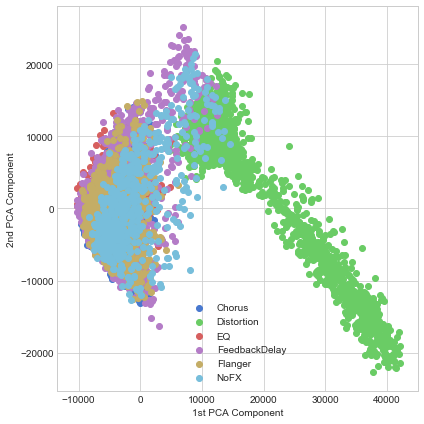

In [63]:
#Creating an instance of a PCA object, which is an object capable of learning and applying PCA from/to data.
#if we want to keep only a given number of components we can use the argument "n_components"
pca = sklearn.decomposition.PCA()

#This will learn PCA projection from data, mind that we are using the features only
pca.fit(features)

#Now we project the data into a from a 7D to a new 7D space (the principal components),
projected_features = pca.transform(features)

#the dimensionality should be the same as the feature
print(projected_features.shape)

#Plot the distribution of the data according to the first two PCA components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 0],
                    projected_features[labels==lab_val, 1],
                    label=lab_name)
    plt.xlabel('1st PCA Component')
    plt.ylabel('2nd PCA Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

(9360, 3)


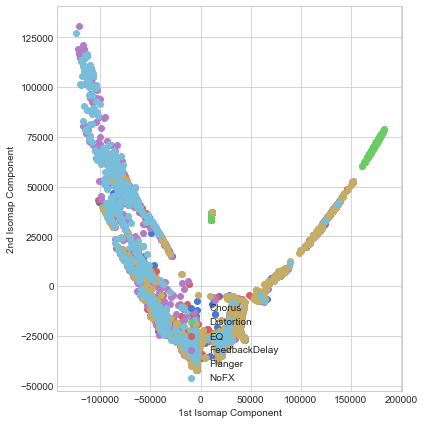

In [65]:
#Creating an instance of a Isomap object, which is an object capable of learning and applying Isomap from/to data.
#if we want to keep only a given number of components we can use the argument "n_components"
isomap = sklearn.manifold.Isomap()

#This will learn Isomap projection from data, mind that we are using the features only
isomap.fit(features)

#Now we project the data into a from a high to a low dimensional space
projected_features = isomap.transform(features)

#the dimensionality should be the same as the feature
print(projected_features.shape)

#Plot the distribution of the data according to the first two Isomap components
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 6))
    for lab_val, lab_name in zip(range(0,len(classes)),classes):
        plt.scatter(projected_features[labels==lab_val, 0],
                    projected_features[labels==lab_val, 1],
                    label=lab_name)
    plt.xlabel('1st Isomap Component')
    plt.ylabel('2nd Isomap Component')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

## SVM Classifier 

In [73]:
#Creating an instance of a SVM classifier
model_SVM = sklearn.svm.SVC(kernel='rbf', C=2.0, verbose=True)

#training the model
model_SVM.fit(feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = model_SVM.predict(feat_test)

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

[LibSVM]Number of mislabeled samples 263 out of 1872
Accuracy: 0.8595085470085471


              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76       407
         1.0       1.00      1.00      1.00       356
         2.0       0.76      0.74      0.75       256
         3.0       1.00      0.99      0.99       368
         4.0       0.78      0.74      0.76       369
         5.0       0.87      0.96      0.91       116

    accuracy                           0.86      1872
   macro avg       0.86      0.87      0.86      1872
weighted avg       0.86      0.86      0.86      1872



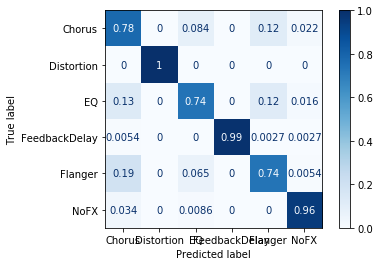

In [74]:
#computing a comprehensive set of performance metrics
print(sklearn.metrics.classification_report(lab_test, lab_predict))

disp = sklearn.metrics.plot_confusion_matrix(model_SVM, feat_test, lab_test, display_labels=classes, cmap=plt.cm.Blues, normalize="true")

## ANN Classifier

In [75]:
#Import the classifier
from sklearn.neural_network import MLPClassifier

##Creating an instance of a MLP classifier
#and setting it some option (max mum epoch, verbose on, activation of neurons)
mlp = MLPClassifier(hidden_layer_sizes=(100,50,100), max_iter=10000, activation='relu', verbose=True)

#train the model
mlp.fit(feat_train, lab_train)

#applying the the model on the test data (features)
lab_predict = mlp.predict(feat_test)
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))

Iteration 1, loss = 1.31832244
Iteration 2, loss = 0.49714155
Iteration 3, loss = 0.38326077
Iteration 4, loss = 0.37172451
Iteration 5, loss = 0.36120091
Iteration 6, loss = 0.35621883
Iteration 7, loss = 0.35579398
Iteration 8, loss = 0.34984876
Iteration 9, loss = 0.34681580
Iteration 10, loss = 0.34480940
Iteration 11, loss = 0.34436171
Iteration 12, loss = 0.34180453
Iteration 13, loss = 0.34092254
Iteration 14, loss = 0.33880443
Iteration 15, loss = 0.33668622
Iteration 16, loss = 0.33685077
Iteration 17, loss = 0.33428629
Iteration 18, loss = 0.33609655
Iteration 19, loss = 0.33619703
Iteration 20, loss = 0.33350263
Iteration 21, loss = 0.33323458
Iteration 22, loss = 0.33012279
Iteration 23, loss = 0.33462518
Iteration 24, loss = 0.33099811
Iteration 25, loss = 0.33232937
Iteration 26, loss = 0.33139815
Iteration 27, loss = 0.32857398
Iteration 28, loss = 0.32852999
Iteration 29, loss = 0.33046300
Iteration 30, loss = 0.32778244
Iteration 31, loss = 0.32785348
Iteration 32, los

Iteration 253, loss = 0.25429022
Iteration 254, loss = 0.24919921
Iteration 255, loss = 0.25185578
Iteration 256, loss = 0.25000141
Iteration 257, loss = 0.25079364
Iteration 258, loss = 0.25221325
Iteration 259, loss = 0.25088567
Iteration 260, loss = 0.25239657
Iteration 261, loss = 0.24950042
Iteration 262, loss = 0.25085852
Iteration 263, loss = 0.24922983
Iteration 264, loss = 0.25218040
Iteration 265, loss = 0.25406715
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy: 0.8408119658119658


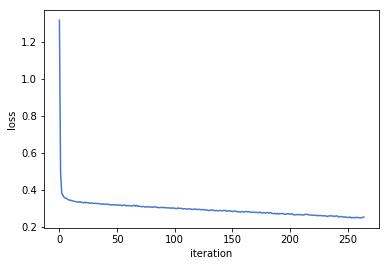

Number of mislabeled samples 298 out of 1872
Accuracy: 0.8408119658119658
              precision    recall  f1-score   support

         0.0       0.71      0.76      0.73       407
         1.0       1.00      1.00      1.00       356
         2.0       0.74      0.72      0.73       256
         3.0       0.99      0.99      0.99       368
         4.0       0.75      0.67      0.71       369
         5.0       0.87      0.95      0.91       116

    accuracy                           0.84      1872
   macro avg       0.84      0.85      0.84      1872
weighted avg       0.84      0.84      0.84      1872



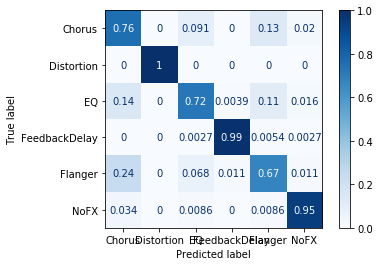

In [76]:
#plotting the loss curve over training iteration 
plt.plot(mlp.loss_curve_)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

#print the number of misclassified samples, accuracy and complete report (using scikit learn metric tools) 
print('Number of mislabeled samples %d out of %d' % ((lab_test != lab_predict).sum(),lab_test.size))
print('Accuracy:',sklearn.metrics.accuracy_score(lab_test, lab_predict))
print(sklearn.metrics.classification_report(lab_test, lab_predict))
disp = sklearn.metrics.plot_confusion_matrix(mlp, feat_test, lab_test, display_labels=classes, cmap=plt.cm.Blues, normalize="true")

In [13]:
#displaying names of misclassified files
results = lab_test == lab_predict

for index, value in results.items():
    if value == False:
        print(classes[int(lab_test[index])])

Chorus
EQ
EQ
Chorus
Chorus
EQ
EQ
Chorus
EQ
FeedbackDelay
Chorus
Chorus
Flanger
EQ
Chorus
Chorus
EQ
EQ
Chorus
Chorus
Flanger
Flanger
Chorus
Flanger
EQ
NoFX
Chorus
Chorus
Chorus
Chorus
Flanger
EQ
Chorus
EQ
Flanger
NoFX
Flanger
EQ
Chorus
Chorus
Chorus
Chorus
EQ
Chorus
EQ
Chorus
EQ
Chorus
EQ
FeedbackDelay
Chorus
Flanger
Flanger
Chorus
Chorus
NoFX
Chorus
Chorus
Chorus
Chorus
EQ
Flanger
Chorus
Chorus
EQ
Chorus
Chorus
Chorus
Chorus
EQ
Flanger
EQ
EQ
NoFX
Chorus
Chorus
Chorus
Flanger
Chorus
Chorus
Chorus
Chorus
Chorus
Chorus
EQ
Chorus
Chorus
Chorus
Chorus
EQ
NoFX
Chorus
Flanger
Chorus
Chorus
Chorus
NoFX
Chorus
EQ
NoFX
EQ
EQ
Chorus
Chorus
Chorus
Flanger
Chorus
EQ
Chorus
Chorus
NoFX
Chorus
Chorus
EQ
Chorus
Chorus
Chorus
Chorus
Chorus
Chorus
NoFX
Chorus
NoFX
EQ
FeedbackDelay
EQ
Chorus
Chorus
Chorus
Chorus
Chorus
Flanger
Chorus
Chorus
Flanger
Chorus
Flanger
Chorus
Chorus
Chorus
Chorus
Chorus


# K-Fold Cross Validation

In [14]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([('scaler', StandardScaler()),
                                  ('classifier', MLPClassifier(hidden_layer_sizes=(10,5), max_iter=10000, activation='relu', verbose=False))
                                 ])

In [15]:
skf = sklearn.model_selection.StratifiedKFold()
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=skf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

{'fit_time': array([19.3610003 , 18.13849616, 13.82849979, 19.99449754, 18.04199767]), 'score_time': array([0.03849983, 0.0309999 , 0.03250051, 0.0290029 , 0.03299952]), 'test_f1_macro': array([0.82177735, 0.76602061, 0.8688928 , 0.80510926, 0.80624033]), 'train_f1_macro': array([0.99618642, 0.99668846, 0.99593815, 0.99494303, 0.99610584]), 'test_accuracy': array([0.82799145, 0.79380342, 0.87179487, 0.81730769, 0.8258547 ]), 'train_accuracy': array([0.9954594 , 0.99639423, 0.99532585, 0.99612714, 0.99559295])} 

Accuracy mean and variance 0.8273504273504274 0.0006408430126378853 

F1 macro mean and variance 0.8136080690647602 0.0011028437689777455 



## Repeated K-Fold Cross Validation

In [16]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([('scaler', StandardScaler()),
                                  ('classifier', MLPClassifier(hidden_layer_sizes=(10,5), max_iter=10000, activation='relu', verbose=False))
                                 ])

In [17]:
rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
scores = sklearn.model_selection.cross_validate(pipe, features, labels, cv=rskf, scoring=('f1_macro', 'accuracy'), return_train_score=True)

print(scores,'\n')
print('Accuracy mean and variance', np.mean(scores['test_accuracy']),np.var(scores['test_accuracy']),'\n')
print('F1 macro mean and variance', np.mean(scores['test_f1_macro']),np.var(scores['test_f1_macro']),'\n')

{'fit_time': array([19.42299891, 24.86049891, 18.61649895, 19.46950126, 20.61600065,
       26.66949892, 16.00249887, 15.17400289, 15.11800146, 19.59550023,
       10.00349951, 14.80302644, 15.27200079, 17.17750335, 18.57397127,
       16.66449761, 18.96700191, 16.35949922, 24.42749953, 24.57199907,
       24.11599994, 23.39900255, 31.38349795, 21.39599872, 27.90449929,
       20.80900002, 27.59949803, 33.01799917, 30.10750103, 21.30950212,
       20.39949965, 23.52600121, 30.00900102, 23.4259975 , 27.59349942,
       19.11499739, 25.18100095, 20.05249929, 17.63899922, 30.26749778,
       31.07349992, 33.12850428, 23.17599845, 18.38700175, 32.65549827,
       19.71599817, 23.61850119, 23.83749843, 28.5764997 , 33.76450086]), 'score_time': array([0.03550124, 0.04000115, 0.03649926, 0.03450084, 0.02900147,
       0.03000093, 0.03049994, 0.02649689, 0.03000021, 0.02950311,
       0.03099966, 0.0270052 , 0.03049827, 0.02902508, 0.02750134,
       0.0345006 , 0.03199816, 0.02949953, 0.03999

## Grid search

In [18]:
# Creating pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([('scaler', StandardScaler()),
                                  ('classifier', MLPClassifier(max_iter=10000, activation='relu'))
                                 ])

rskf = sklearn.model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
grid_params = {
    'classifier__hidden_layer_sizes':[(100,50,100)]
}
                                                       
grid_search = sklearn.model_selection.GridSearchCV(estimator=pipe, param_grid=grid_params, scoring='accuracy',cv=rskf,n_jobs=3)
grid_search.fit(features, labels)
                                                       
print('best set of parameters', grid_search.best_params_)
print('associated best score',grid_search.best_score_)                                                       
                                                       

best set of parameters {'classifier__hidden_layer_sizes': (100, 50, 100)}
associated best score 0.9429166666666667
